In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import copy
from collections import namedtuple
import os
import random
import shutil
import time
from pytorch_lightning import LightningModule

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
os.environ['CUDA_VISIBLE_DEVICE'] = "0"

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
train_dir = '/LVM_data/ldap_howard/NCT-CRC-HE-100K/'

In [4]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           #transforms.RandomRotation(5),
                           #transforms.RandomHorizontalFlip(0.5),
                           #transforms.RandomVerticalFlip(0.5),
                           #transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [5]:
train_data = datasets.ImageFolder(root = train_dir, transform = train_transforms)

In [6]:
VALID_RATIO = 0.8

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
#print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 80000
Number of validation examples: 20000


In [9]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)


In [10]:
def load_resnet18_model():
    model = models.resnet18(weights="IMAGENET1K_V1")
    model.eval()
    return model

def load_resnet34_model():
    model = models.resnet34(weights="IMAGENET1K_V1")
    model.eval()
    return model

In [11]:
model = load_resnet18_model().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00005)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

11,689,512 total parameters.
11,689,512 training parameters.



In [16]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    merged_tensor = torch.zeros(1,)
    
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        merged_tensor = merged_tensor.to(device)
        optimizer.zero_grad()
        outputs = model(image)
                        
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
                                
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [30]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
min_loss = np.inf
epochs = 50

for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    #if epoch == 30:
        #optimizer = optim.Adam(model.parameters(), lr=0.0001)
        #criterion = nn.CrossEntropyLoss()
    
    train_epoch_loss, train_epoch_acc = train(model, train_iterator, 
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_iterator,  
                                                 criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    
    if min_loss > valid_epoch_loss:
        print('save model!')
        print('valid_loss: '+str(valid_epoch_loss))
        torch.save(model.state_dict(), 'resnet18NCT_0222.pt')
        min_loss = valid_epoch_loss

    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

save model!
valid_loss: 0.027743842313847186
Training loss: 0.142, training acc: 96.595
Validation loss: 0.028, validation acc: 99.065
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.028, training acc: 99.085
Validation loss: 0.040, validation acc: 98.850
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

save model!
valid_loss: 0.01663523905287516
Training loss: 0.021, training acc: 99.308
Validation loss: 0.017, validation acc: 99.450
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.017, training acc: 99.455
Validation loss: 0.037, validation acc: 98.785
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.015, training acc: 99.502
Validation loss: 0.022, validation acc: 99.315
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.014, training acc: 99.544
Validation loss: 0.028, validation acc: 99.195
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.010, training acc: 99.688
Validation loss: 0.040, validation acc: 98.890
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.010, training acc: 99.679
Validation loss: 0.027, validation acc: 99.235
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.009, training acc: 99.749
Validation loss: 0.018, validation acc: 99.480
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.008, training acc: 99.757
Validation loss: 0.020, validation acc: 99.445
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.008, training acc: 99.729
Validation loss: 0.020, validation acc: 99.445
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.006, training acc: 99.811
Validation loss: 0.018, validation acc: 99.480
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

Validation


  0%|          | 0/313 [00:00<?, ?it/s]

Training loss: 0.006, training acc: 99.809
Validation loss: 0.023, validation acc: 99.400
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/1250 [00:00<?, ?it/s]

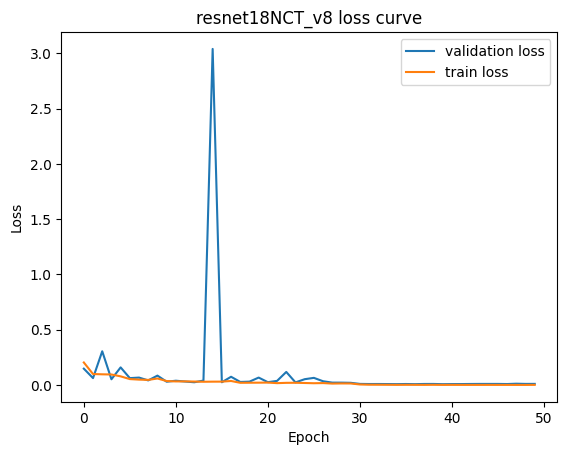

In [ ]:
plt.plot(valid_loss, label='validation loss')
plt.plot(train_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('resnet18NCT_v8 loss curve')
x_ticks = [f'{(i+1):.0f}' if (i+1) % 10 == 0 else '' for i in range(20)]
#plt.xticks(range(120), x_ticks)
plt.legend()
plt.show()

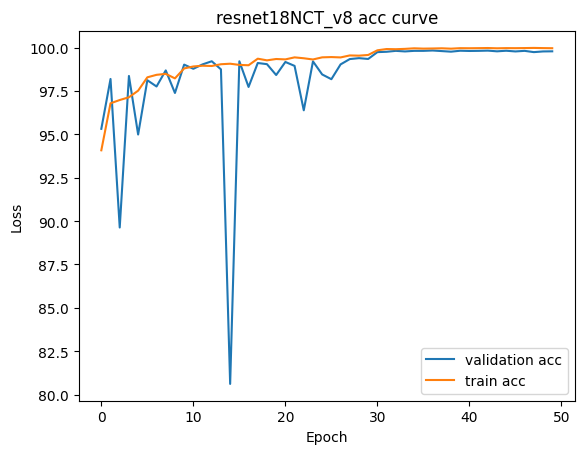

In [ ]:
plt.plot(valid_acc, label='validation acc')
plt.plot(train_acc, label='train acc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('resnet18NCT_v8 acc curve')
x_ticks = [f'{(i+1):.0f}' if (i+1) % 2 == 0 else '' for i in range(20)]
#plt.xticks(range(120), x_ticks)
plt.legend()
plt.show()

In [17]:
test_data = datasets.ImageFolder(root = '/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/', transform = test_transforms)
test_iterator = data.DataLoader(test_data, batch_size = 256)
model.load_state_dict(torch.load('resnet18NCT_0307.pt'))

<All keys matched successfully>

In [18]:
validate(model, test_iterator, criterion)

Validation


  0%|          | 0/29 [00:00<?, ?it/s]

(0.6799356658651458, 92.0891364902507)

In [20]:
def get_predictions(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    merged_tensor = torch.zeros(1,)
    preds_all = torch.tensor([]).to(device)
    valid_running_correct = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image, labels = data
            image = image.to(device)
            outputs = model(image)
            _, preds = torch.max(outputs.data, 1)
            preds_all = torch.cat((preds_all, preds),0)
    return preds_all

In [34]:
pretrained_size = 224
infer_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [46]:
pretrained_stds

[0.229, 0.224, 0.225]

In [21]:
pred_labels = get_predictions(model, test_iterator)

  0%|          | 0/29 [00:00<?, ?it/s]

In [24]:
infer_dir = '/ORCA_lake/TCGA-COAD/png/COAD0605_1_v3_norm/'
infer_data = datasets.ImageFolder(root = infer_dir, 
                                 transform = infer_transforms)

In [25]:
infer_iterator = data.DataLoader(infer_data, 
                                batch_size = 64)

In [26]:
model.load_state_dict(torch.load('resnet34NCT_0229.pt'))

<All keys matched successfully>

In [36]:
pred_labels = get_predictions(model, infer_iterator)

NameError: name 'infer_iterator' is not defined

In [21]:
pred_labels

tensor([2., 2., 8.,  ..., 2., 2., 2.], device='cuda:0')

In [22]:
is_adi = (pred_labels == 0).sum().item()
is_back = (pred_labels == 1).sum().item()
is_deb = (pred_labels == 2).sum().item()
is_lym = (pred_labels == 3).sum().item()
is_muc = (pred_labels == 4).sum().item()
is_mus = (pred_labels == 5).sum().item()
is_norm = (pred_labels == 6).sum().item()
is_str = (pred_labels == 7).sum().item()
is_tum = (pred_labels == 8).sum().item()
print(is_adi, is_back, is_deb, is_lym, is_muc, is_mus, is_norm, is_str, is_tum)


1267 847 533 465 1069 671 779 298 1251


## External test ##

In [34]:
i=0
tumor_root = '/ORCA_lake/TCGA-COAD/resnet18NCT_0307/TUM/'
if os.path.exists(tumor_root) == False: os.makedirs(tumor_root)
tumor_root = '/ORCA_lake/TCGA-COAD/resnet18NCT_0307/TUM/CRC_VAL_HE_7K/'
if os.path.exists(tumor_root) == False: os.makedirs(tumor_root)
for label1 in pred_labels:   
    if label1 == 8:
        start_dir = test_data.samples[i][0]
        type_name = start_dir.split('/')[4]
        slide_name = start_dir.split('/')[5]
        slide_path = os.path.join(tumor_root, slide_name)
        print(slide_path)
      
        #if not os.path.exists(slide_path):
        #    os.makedirs(slide_path)
        shutil.copy(start_dir, slide_path)

    i+=1


/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUC-TCGA-TWFYGQNA.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA-EQTPGRFV.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA-FYLQYWPG.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA-IRTDFLAE.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA-MNGYMMNC.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA-MRQEYFIW.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA-MVRFAWAT.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA-NWELKCYM.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA-QEPHASHD.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA-RDRGIRWD.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA-RFKPPCHT.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA-VQRTNVDF.tif
/ORCA_lake/TCGA-COAD/resnet18NCT_0307/STR/CRC_VAL_HE_7K/MUS-TCGA

## Inference on TCGA-CRC-DX ##

In [21]:
i=0
tumor_root = '/ORCA_lake/TCGA-COAD/resnet34NCT_0229/ADI/CPTAC/'
#if os.path.exists(tumor_root) == False: os.makedirs(tumor_root)
count = 0
for label1 in pred_labels:   
    if label1 == 8:
        start_dir = test_data.samples[i][0]
        type_name = start_dir.split('/')[4]
        if type_name == 'TUM': count+=1
        print(start_dir)
               
        #if not os.path.exists(tumor_root):
        #    os.makedirs(tumor_root)
        #shutil.copy(start_dir, tumor_root)

    i+=1
print(count)

/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/MUC/MUC-TCGA-QADAVPSQ.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/MUC/MUC-TCGA-SDASNDVG.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/MUS/MUS-TCGA-MQLVLGAC.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/MUS/MUS-TCGA-STQEACCP.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-AKRKNWMN.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-ANIPDWQD.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-EQTDFKTE.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-ETIGILEA.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-GHINQVKE.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-GLSWPYYC.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-GMFIYKPM.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-IETVHKWL.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-IVDMVMIQ.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-KFQFHIDC.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-KQWNYYND.tif
/ORCA_lake/TCGA-COAD/CRC-VAL-HE-7K/NORM/NORM-TCGA-PKRYMWQY.tif
